<a href="https://colab.research.google.com/github/casjunior93/redes-neurais-Univesp/blob/main/MLP_para_regress%C3%A3o_com_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COM510 - Redes Neurais

## Exercício de Apoio - Semana 03 (Parte 02)

### Rede Neural Multilayer Perceptron MLP (Regressão)

- Carregamento dos pacotes necessários
- Geração dos dados
- Definição do modelo
- Treinamento de modelo
- Gráficos e Avaliação
- Exercício de Apoio

# Pacotes

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
# verificando disponibilidade da gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dados

## Geração dos Dados

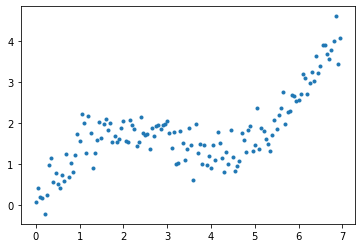

(140,)
CPU times: user 125 ms, sys: 83.1 ms, total: 208 ms
Wall time: 116 ms


In [15]:
%%time
#A função arange cria um arranjo contendo uma seqüência de valores especificados em um intervalo com início e fim dados, espaçados de maneira uniforme.
X = np.arange(0,7,0.05)
Y = np.sin(X) + 0.3*np.random.randn(X.shape[0]) + 0.5*X
plt.plot(X,Y, '.')
plt.show()
print(X.shape)

## Separação Treino/Validação/Teste

(22, 1)
(6, 1)
(112, 1)


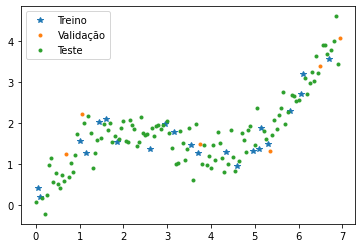

CPU times: user 179 ms, sys: 23.1 ms, total: 202 ms
Wall time: 492 ms


In [17]:
%%time
# reshape: Dá uma nova forma a uma matriz sem alterar seus dados.
# Matriz de 1 coluna
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

# Separação desenvolvimento (30) e teste (70)
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

# Separação treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

plt.plot(X_train, Y_train, '*', label='Treino')
plt.plot(X_val, Y_val, '.', label='Validação')
plt.plot(X_test, Y_test, '.', label='Teste')
plt.legend()
plt.show()

## Transformação dos dados em tensores Pytorch

In [18]:
%%time
x_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(Y_train).to(device)

x_val = torch.FloatTensor(X_val).to(device)
y_val = torch.FloatTensor(Y_val).to(device)

x_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(Y_test).to(device)


CPU times: user 1.56 ms, sys: 153 µs, total: 1.71 ms
Wall time: 1.18 ms


# Modelo com uma única camada (linear)

In [19]:
class MLPLin(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLPLin,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,output_dim, device = device),
        )
    def forward(self,x):
        out =  self.rede(x)
        return out

## Instanciação do Modelo

In [27]:
%%time
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes

modeloLin = MLPLin(input_dim,output_dim)
modeloLin = modeloLin.to(device)

CPU times: user 1.82 ms, sys: 0 ns, total: 1.82 ms
Wall time: 1.39 ms


In [29]:
%%time
from torchsummary import summary

print(modeloLin)
summary(modeloLin, (100,1))

MLPLin(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 100, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
CPU times: user 4.49 ms, sys: 74 µs, total: 4.57 ms
Wall time: 7.08 ms


## Otimizador e Função de Custo

In [30]:
%%time
eta = 0.02
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(modeloLin.parameters(),lr=eta)

CPU times: user 157 µs, sys: 0 ns, total: 157 µs
Wall time: 161 µs


## Treinamento

### Laço de treinamento da rede




In [31]:
%%time
def train_network(model,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses):
    for epoch in range(num_epochs):
        # zerando os gradientes da época anterior
        optimizer.zero_grad()
        
        # fase de propagação
        output_train = model(x_train)

        # cálculo do erro (função de custo - loss function)
        loss_train = loss_function(output_train, y_train)

        # fase de retroprogação
        loss_train.backward()

        # atualização dos pesos da rede
        optimizer.step()

        # avaliando o modelo com o conjunto de validação
        output_val = model(x_val)
        loss_val = loss_function(output_val,y_val)

        train_losses[epoch] = loss_train.item()
        val_losses[epoch] = loss_val.item()

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Erro Treino: {loss_train.item():.4f},  Erro Validação: {loss_val.item():.3f}")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [33]:
%%time
num_epochs = 5000
train_losses = np.zeros(num_epochs)
val_losses  = np.zeros(num_epochs)

train_network(modeloLin,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses)

Epoch 1000/5000, Erro Treino: 0.3586,  Erro Validação: 0.907
Epoch 2000/5000, Erro Treino: 0.3586,  Erro Validação: 0.907
Epoch 3000/5000, Erro Treino: 0.3586,  Erro Validação: 0.907
Epoch 4000/5000, Erro Treino: 0.3586,  Erro Validação: 0.907
Epoch 5000/5000, Erro Treino: 0.3586,  Erro Validação: 0.907
CPU times: user 3.29 s, sys: 162 ms, total: 3.45 s
Wall time: 3.43 s


## Resultados

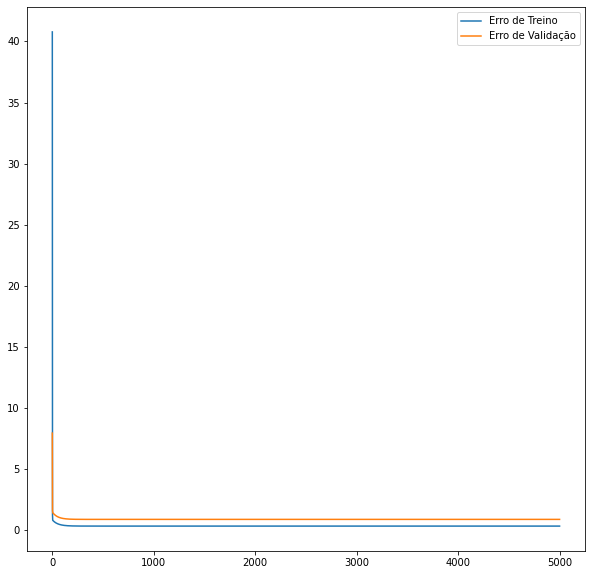

CPU times: user 168 ms, sys: 114 ms, total: 282 ms
Wall time: 168 ms


In [34]:
%%time
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.legend()
plt.show()

In [38]:
%%time
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = modeloLin(x_train)
    predictions_val = modeloLin(x_val)
    predictions_test = modeloLin(x_test)

erro_train = loss_function(predictions_train,y_train)
erro_val = loss_function(predictions_val,y_val)
erro_test = loss_function(predictions_test,y_test)

# from sklearn.metrics import accuracy_score
# acc_train = accuracy_score(x_train, predictions_train)

print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

Erro de Treino: 0.3585873544216156
Erro de Validação: 0.9072713851928711
Erro de Teste: 0.41426345705986023
CPU times: user 2.26 ms, sys: 1.03 ms, total: 3.29 ms
Wall time: 2.53 ms


In [46]:
%%time
#Dados para cpu - Dá erro quando tenta plotar o gráfico com os dados na GPU
x_train, y_train, x_test, y_test = x_train.to('cpu'), y_train.to('cpu'), x_test.to('cpu'), y_test.to('cpu')
predictions_train = predictions_train.to('cpu')
predictions_val = predictions_val.to('cpu')
predictions_test = predictions_test.to('cpu')

CPU times: user 988 µs, sys: 0 ns, total: 988 µs
Wall time: 997 µs


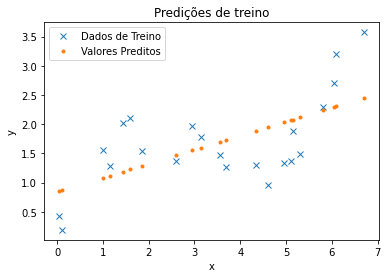

CPU times: user 162 ms, sys: 109 ms, total: 271 ms
Wall time: 153 ms


In [48]:
%%time
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predições de treino')
plt.legend()
plt.show()

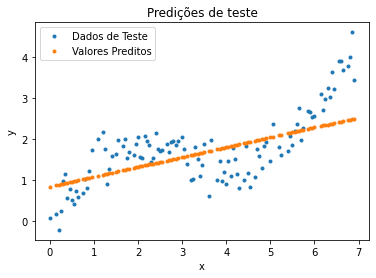

CPU times: user 160 ms, sys: 102 ms, total: 262 ms
Wall time: 154 ms


In [50]:
%%time
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predições de teste')
plt.legend()
plt.show()

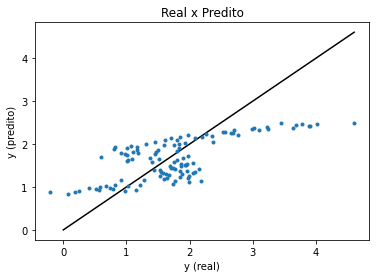

CPU times: user 126 ms, sys: 83.6 ms, total: 209 ms
Wall time: 115 ms


In [52]:
%%time
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.title('Real x Predito')
# plt.legend()
plt.show()

# Modelo com várias camadas

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,output_dim),
        )
    def forward(self,x):
        out =  self.rede(x)
        return out

## Instanciação do Modelo

In [ ]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes

modelo = MLP(input_dim,output_dim)

In [ ]:
from torchsummary import summary

print(modelo)
summary(modelo, (100,1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 512]           1,024
              ReLU-2             [-1, 100, 512]               0
            Linear-3             [-1, 100, 256]         131,328
              ReLU-4             [-1, 100, 256]               0
            Linear-5             [-1, 100, 128]          32,896
              ReLU-6             [-1, 100, 128]               0
            Linear-7              [-1, 100, 64]           8,256
              ReLU-8  

## Otimizador e Função de Custo

In [ ]:
eta = 0.02
loss_function = nn.MSELoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelo.parameters(),lr=eta)

## Treinamento

### Transformação dos dados em tensores Pytorch

In [ ]:
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(Y_train)

x_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(Y_val)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(Y_test)


In [ ]:
# verificando disponibilidade da gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Laço de treinamento da rede




In [ ]:
def train_network(model,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses):
    for epoch in range(num_epochs):
        # zerando os gradientes da época anterior
        optimizer.zero_grad()
        
        # fase de propagação
        output_train = model(x_train)

        # cálculo do erro (função de custo - loss function)
        loss_train = loss_function(output_train, y_train)

        # fase de retroprogação
        loss_train.backward()

        # atualização dos pesos da rede
        optimizer.step()

        # avaliando o modelo com o conjunto de validação
        output_val = model(x_val)
        loss_val = loss_function(output_val,y_val)

        train_losses[epoch] = loss_train.item()
        val_losses[epoch] = loss_val.item()

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Erro Treino: {loss_train.item():.4f},  Erro Validação: {loss_val.item():.3f}")

In [ ]:
num_epochs = 20000
train_losses = np.zeros(num_epochs)
val_losses  = np.zeros(num_epochs)

train_network(modelo,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses)

Epoch 1000/20000, Erro Treino: 0.1841,  Erro Validação: 0.696
Epoch 2000/20000, Erro Treino: 0.1287,  Erro Validação: 0.482
Epoch 3000/20000, Erro Treino: 0.0724,  Erro Validação: 0.198
Epoch 4000/20000, Erro Treino: 0.0794,  Erro Validação: 0.215
Epoch 5000/20000, Erro Treino: 0.0470,  Erro Validação: 0.094
Epoch 6000/20000, Erro Treino: 0.0582,  Erro Validação: 0.123
Epoch 7000/20000, Erro Treino: 0.0376,  Erro Validação: 0.068
Epoch 8000/20000, Erro Treino: 0.0443,  Erro Validação: 0.082
Epoch 9000/20000, Erro Treino: 0.0372,  Erro Validação: 0.071
Epoch 10000/20000, Erro Treino: 0.0455,  Erro Validação: 0.093
Epoch 11000/20000, Erro Treino: 0.0305,  Erro Validação: 0.062
Epoch 12000/20000, Erro Treino: 0.0385,  Erro Validação: 0.106
Epoch 13000/20000, Erro Treino: 0.0175,  Erro Validação: 0.098
Epoch 14000/20000, Erro Treino: 0.0168,  Erro Validação: 0.221
Epoch 15000/20000, Erro Treino: 0.0126,  Erro Validação: 0.093
Epoch 16000/20000, Erro Treino: 0.0319,  Erro Validação: 0.076
E

## Resultados

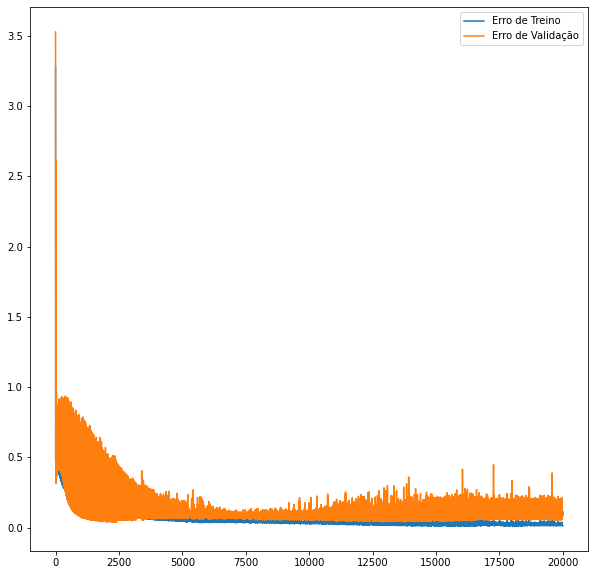

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.legend()
plt.show()

In [ ]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = modelo(x_train)
    predictions_val = modelo(x_val)
    predictions_test = modelo(x_test)

erro_train = loss_function(predictions_train,y_train)
erro_val = loss_function(predictions_val,y_val)
erro_test = loss_function(predictions_test,y_test)

# from sklearn.metrics import accuracy_score
# acc_train = accuracy_score(x_train, predictions_train)

print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

Erro de Treino: 0.011329781264066696
Erro de Validação: 0.0855075791478157
Erro de Teste: 0.13274773955345154


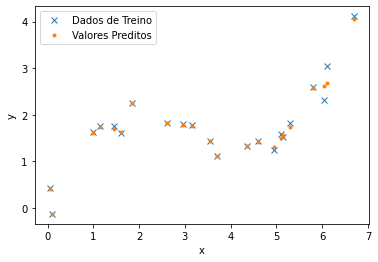

In [ ]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

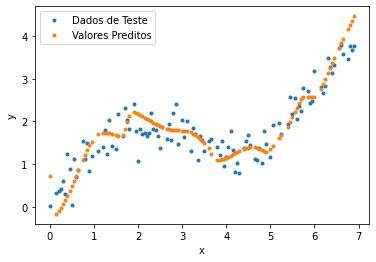

In [ ]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

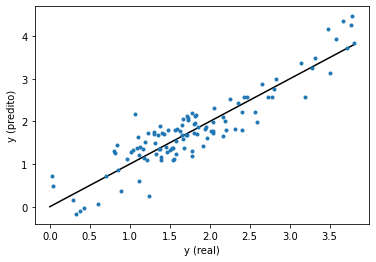

In [ ]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
# plt.legend()
plt.show()

# Exercício de Apoio (Regressão)



### Realizar as seguintes atividades:


1. Treinar o modelo com outras configuração (variar o número de camadas e neurônios
2. Avaliar o processo de treinamento considerando outros valores para a taxa de aprendizagem
3. Avaliar outras funções de ativação:
*   Sigmoid Logística (nn.Sigmoid)
*   Relu (nn.ReLU)